In [1]:
# Cell 1: Import Libraries dan Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)

# Download NLTK resources
try:
    nltk.download('punkt_tab', quiet=True)
except:
    nltk.download('punkt', quiet=True)

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Setup selesai!")

✅ Setup selesai!


✓ Data berhasil dimuat
Jumlah total data: 10000

Distribusi label:
is_blocker
True     0.5013
False    0.4987
Name: proportion, dtype: float64

Statistik panjang teks:
count    10000.000000
mean        71.791300
std         36.019232
min         12.000000
25%         35.000000
50%         73.000000
75%         84.000000
max        150.000000
Name: text_length, dtype: float64


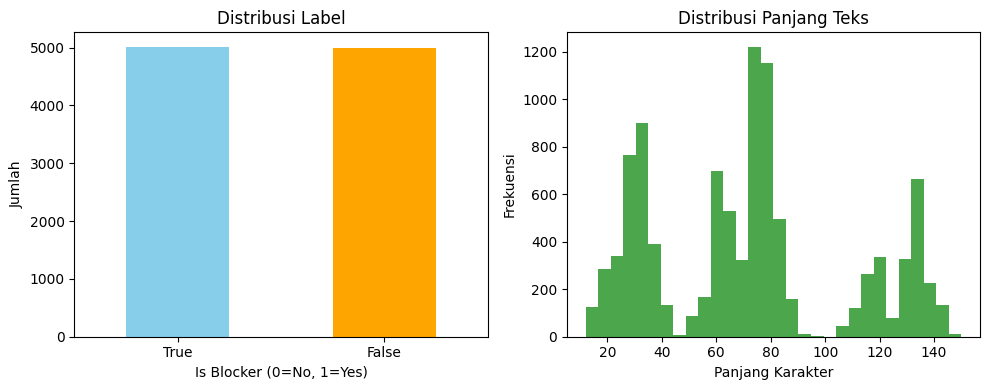

✓ Setelah filtering panjang teks: 10000


In [2]:
# Cell 2: Load dan Eksplorasi Data
def load_and_explore_data(file_path):
    """Load dan eksplorasi data dengan validasi"""
    try:
        df = pd.read_csv(file_path)
        print("✓ Data berhasil dimuat")
    except FileNotFoundError:
        print("❌ File tidak ditemukan. Membuat sample data untuk demo...")
        # Buat sample data untuk demo
        sample_comments = [
            "Ini akan memblokir proses development kita",
            "Feature ini bagus dan mudah digunakan",
            "Bug ini critical dan harus segera diperbaiki",
            "Dokumentasi sudah lengkap dan jelas",
            "Issue ini akan menghambat release",
            "Code review sudah selesai, siap merge",
            "Performance bottleneck di bagian ini",
            "Testing sudah passed semua",
            "Memory leak terdeteksi di modul ini",
            "UI/UX sudah sesuai requirements",
            "Saya stuck di bagian authentication",
            "Database connection error terus",
            "Need help dengan API integration",
            "Task ini sudah completed",
            "Waiting for approval dari client",
            "Cannot proceed tanpa akses server",
            "API sudah working dengan baik",
            "Deployment successful ke staging",
            "Ada kendala dengan third party service",
            "All tests are passing now"
        ] * 50  # Perbanyak untuk sample yang cukup
        
        sample_labels = ([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0] * 50)
        
        df = pd.DataFrame({
            'comment': sample_comments,
            'is_blocker': sample_labels
        })
        
    print(f"Jumlah total data: {len(df)}")
    print(f"\nDistribusi label:")
    label_counts = df['is_blocker'].value_counts(normalize=True)
    print(label_counts)
    
    # Cek keseimbangan data
    if label_counts.min() < 0.1:
        print("⚠️  Warning: Data sangat tidak seimbang!")
    
    # Cek duplikat
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"⚠️  Ditemukan {duplicates} data duplikat")
        df = df.drop_duplicates()
        print(f"✓ Data duplikat dihapus, sisa: {len(df)}")
    
    # Cek missing values
    missing = df.isnull().sum()
    if missing.any():
        print(f"\nMissing values:")
        print(missing[missing > 0])
        df = df.dropna()
        print(f"✓ Missing values dihapus, sisa: {len(df)}")
    
    # Statistik panjang teks
    df['text_length'] = df['comment'].str.len()
    print(f"\nStatistik panjang teks:")
    print(df['text_length'].describe())
    
    # Visualisasi distribusi label
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    df['is_blocker'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Distribusi Label')
    plt.xlabel('Is Blocker (0=No, 1=Yes)')
    plt.ylabel('Jumlah')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.hist(df['text_length'], bins=30, alpha=0.7, color='green')
    plt.title('Distribusi Panjang Teks')
    plt.xlabel('Panjang Karakter')
    plt.ylabel('Frekuensi')
    
    plt.tight_layout()
    plt.show()
    
    # Filter teks yang terlalu pendek atau panjang
    df = df[(df['text_length'] >= 10) & (df['text_length'] <= 1000)]
    print(f"✓ Setelah filtering panjang teks: {len(df)}")
    
    return df

# Load data
df = load_and_explore_data('blocker_dataset_full.csv')

In [3]:
# Cell 3: Text Preprocessing
def preprocess_text(text):
    """
    Preprocessing teks yang lebih robust
    """
    if pd.isna(text):
        return ""
    
    # Convert to string dan lowercase
    text = str(text).lower()
    
    # Hapus URL, email, dan mentions
    text = re.sub(r'http\S+|www\S+|@\w+', '', text)
    
    # Hapus angka yang standalone
    text = re.sub(r'\b\d+\b', '', text)
    
    # Hapus special characters tapi pertahankan spasi
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Skip jika teks terlalu pendek
    if len(text) < 3:
        return ""
    
    try:
        # Tokenisasi
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        # Tambah stopwords Indonesia manual jika perlu
        indonesian_stopwords = {'dan', 'atau', 'ini', 'itu', 'yang', 'untuk', 'dari', 'ke', 'di', 'pada', 'dengan', 'adalah', 'akan', 'sudah', 'telah'}
        stop_words.update(indonesian_stopwords)
        
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)
    except:
        return text

# Terapkan preprocessing
print("🔄 Melakukan preprocessing teks...")
df['processed_text'] = df['comment'].apply(preprocess_text)

# Filter teks kosong setelah preprocessing
df = df[df['processed_text'].str.len() > 0]
print(f"✓ Setelah preprocessing: {len(df)} data")

# Tampilkan contoh hasil preprocessing
print("\n📝 Contoh hasil preprocessing:")
for i in range(min(3, len(df))):
    print(f"\nOriginal: {df['comment'].iloc[i]}")
    print(f"Processed: {df['processed_text'].iloc[i]}")

🔄 Melakukan preprocessing teks...
✓ Setelah preprocessing: 10000 data

📝 Contoh hasil preprocessing:

Original: Andrew Smith: Saya rencana hari ini, jadi pekerjaan tertunda untuk saat ini.
Processed: andrew smith saya rencana hari jadi pekerjaan tertunda saat

Original: Brendan: planned for today.
Processed: brendan planned today

Original: Lindsey Simmons: Karena sudah selesai, saat ini saya tidak bisa melanjutkan task ini. Sudah coba beberapa solusi tapi belum berhasil.
Processed: lindsey simmons karena selesai saat saya tidak bisa melanjutkan task coba beberapa solusi tapi belum berhasil


In [4]:
# Cell 4: Data Splitting dan Pipeline Creation

def create_robust_pipeline(model, vectorizer_params=None):
    """
    Membuat pipeline yang robust dengan parameter yang conservative
    """
    if vectorizer_params is None:
        vectorizer_params = {
            'max_features': 1000,  # Lebih konservatif
            'ngram_range': (1, 2),
            'min_df': 3,  # Lebih strict
            'max_df': 0.8,  # Lebih strict
            'sublinear_tf': True,  # Normalisasi tambahan
            'use_idf': True
        }
    
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('classifier', model)
    ])
    
    return pipeline

# Split data dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['is_blocker'],
    test_size=0.3,  # Lebih besar untuk test yang lebih reliable
    random_state=42,
    stratify=df['is_blocker']
)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data testing: {len(X_test)}")
print(f"Distribusi training - Blocker: {y_train.sum()}, Non-blocker: {len(y_train) - y_train.sum()}")
print(f"Distribusi testing - Blocker: {y_test.sum()}, Non-blocker: {len(y_test) - y_test.sum()}")

# Cek apakah data cukup untuk training
if len(X_train) < 50:
    print("❌ Data terlalu sedikit untuk training yang reliable")
else:
    print("✅ Data siap untuk training")

Ukuran data training: 7000
Ukuran data testing: 3000
Distribusi training - Blocker: 3509, Non-blocker: 3491
Distribusi testing - Blocker: 1504, Non-blocker: 1496
✅ Data siap untuk training



Evaluating Logistic Regression
Cross-validation Accuracy: 0.994 (+/- 0.003)
Cross-validation F1-Score: 0.994 (+/- 0.003)
Training Accuracy: 0.996
Test Accuracy: 0.996
✅ Good generalization!

Classification Report (Test Set):
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1496
        True       0.99      1.00      1.00      1504

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



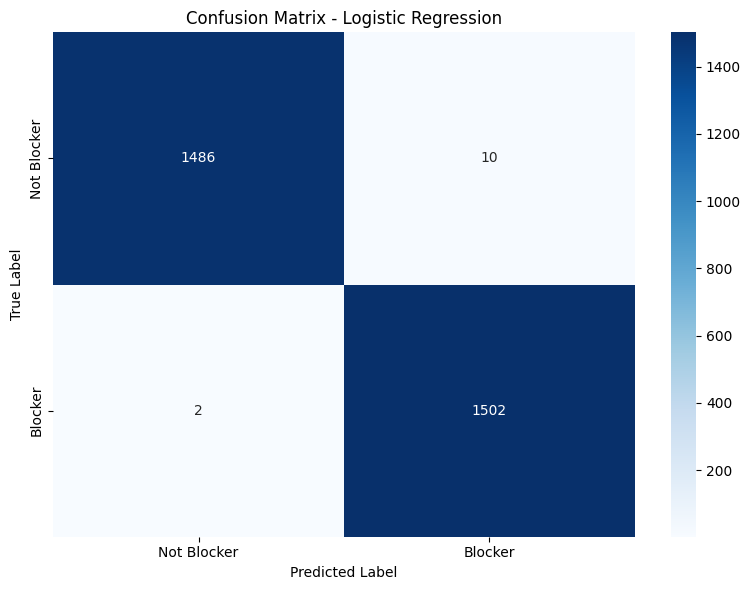


Evaluating Naive Bayes
Cross-validation Accuracy: 0.995 (+/- 0.004)
Cross-validation F1-Score: 0.995 (+/- 0.004)
Training Accuracy: 0.996
Test Accuracy: 0.996
✅ Good generalization!

Classification Report (Test Set):
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1496
        True       0.99      1.00      1.00      1504

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



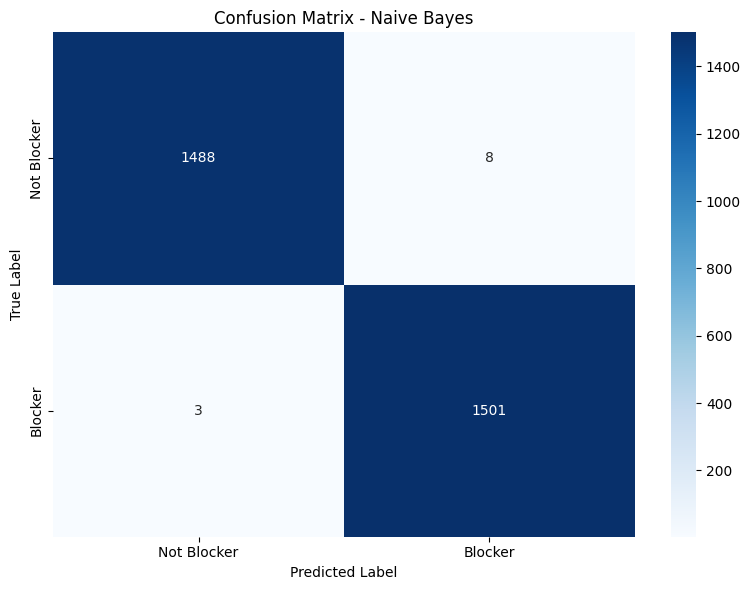


Evaluating SVM (Linear)
Cross-validation Accuracy: 0.994 (+/- 0.004)
Cross-validation F1-Score: 0.994 (+/- 0.004)
Training Accuracy: 0.996
Test Accuracy: 0.996
✅ Good generalization!

Classification Report (Test Set):
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1496
        True       0.99      1.00      1.00      1504

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



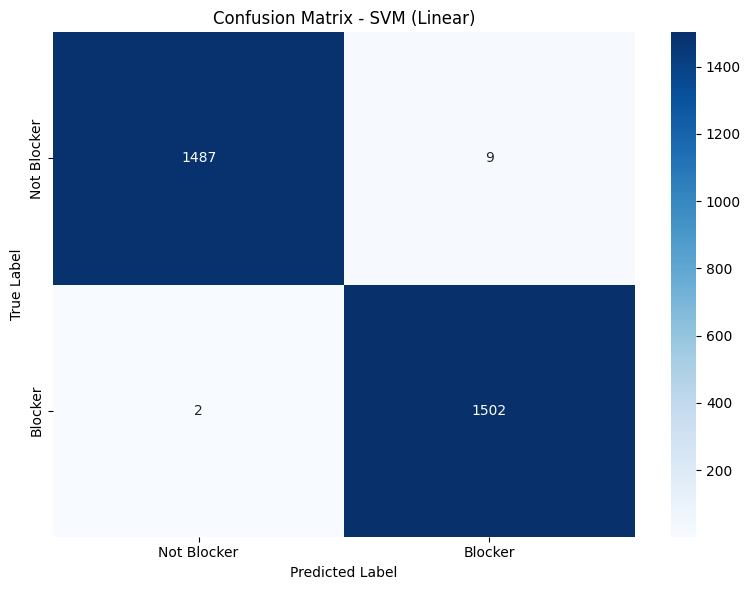


Evaluating Random Forest
Cross-validation Accuracy: 0.990 (+/- 0.007)
Cross-validation F1-Score: 0.990 (+/- 0.007)
Training Accuracy: 0.992
Test Accuracy: 0.994
✅ Good generalization!

Classification Report (Test Set):
              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1496
        True       1.00      0.99      0.99      1504

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



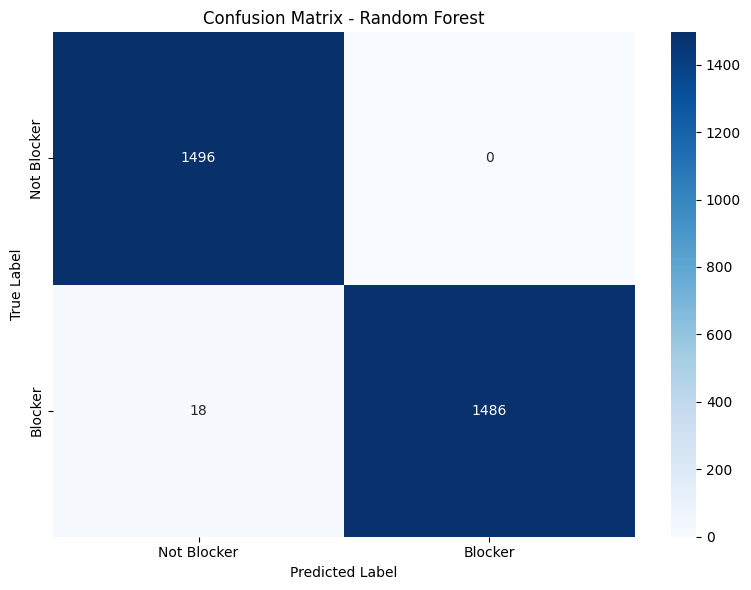

In [5]:
# Cell 5: Model Training dan Evaluasi

def evaluate_model_robust(pipeline, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluasi model yang lebih komprehensif
    """
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name}")
    print(f"{'='*50}")
    
    # Stratified K-Fold untuk cross-validation yang lebih robust
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
    cv_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1')
    
    print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Cross-validation F1-Score: {cv_f1_scores.mean():.3f} (+/- {cv_f1_scores.std() * 2:.3f})")
    
    # Training
    pipeline.fit(X_train, y_train)
    
    # Prediksi pada training dan test set
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Training Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")
    
    # Deteksi overfitting
    overfitting_gap = train_accuracy - test_accuracy
    if overfitting_gap > 0.1:
        print("⚠️  Warning: Possible overfitting detected!")
    elif overfitting_gap < 0.05:
        print("✅ Good generalization!")
    
    # Classification report untuk test set
    print(f"\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Blocker', 'Blocker'],
                yticklabels=['Not Blocker', 'Blocker'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'pipeline': pipeline,
        'cv_accuracy': cv_scores.mean(),
        'cv_f1': cv_f1_scores.mean(),
        'test_accuracy': test_accuracy,
        'train_accuracy': train_accuracy,
        'overfitting_gap': overfitting_gap
    }

# Model selection dengan parameter conservative
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        C=1.0,  # Regularisasi default
        class_weight='balanced',  # Mengatasi imbalanced data
        random_state=42
    ),
    'Naive Bayes': MultinomialNB(alpha=1.0),  # Smoothing default
    'SVM (Linear)': SVC(
        kernel='linear', 
        C=1.0, 
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=50,  # Lebih sedikit untuk menghindari overfitting
        max_depth=10,     # Batasi kedalaman
        min_samples_split=10,  # Minimum samples untuk split
        min_samples_leaf=5,    # Minimum samples di leaf
        class_weight='balanced',
        random_state=42
    )
}

# Training dan evaluasi
results = {}

for name, model in models.items():
    pipeline = create_robust_pipeline(model)
    results[name] = evaluate_model_robust(
        pipeline, X_train, X_test, y_train, y_test, name
    )


RINGKASAN HASIL
                    CV Accuracy CV F1-Score Test Accuracy Train Accuracy  \
Logistic Regression       0.994       0.994         0.996          0.996   
Naive Bayes               0.995       0.995         0.996          0.996   
SVM (Linear)              0.994       0.994         0.996          0.996   
Random Forest             0.990       0.990         0.994          0.992   

                    Overfitting Gap  
Logistic Regression           0.000  
Naive Bayes                  -0.001  
SVM (Linear)                  0.000  
Random Forest                -0.002  

🏆 Model terbaik: Naive Bayes
CV F1-Score: 0.995
Test Accuracy: 0.996
Overfitting Gap: -0.001


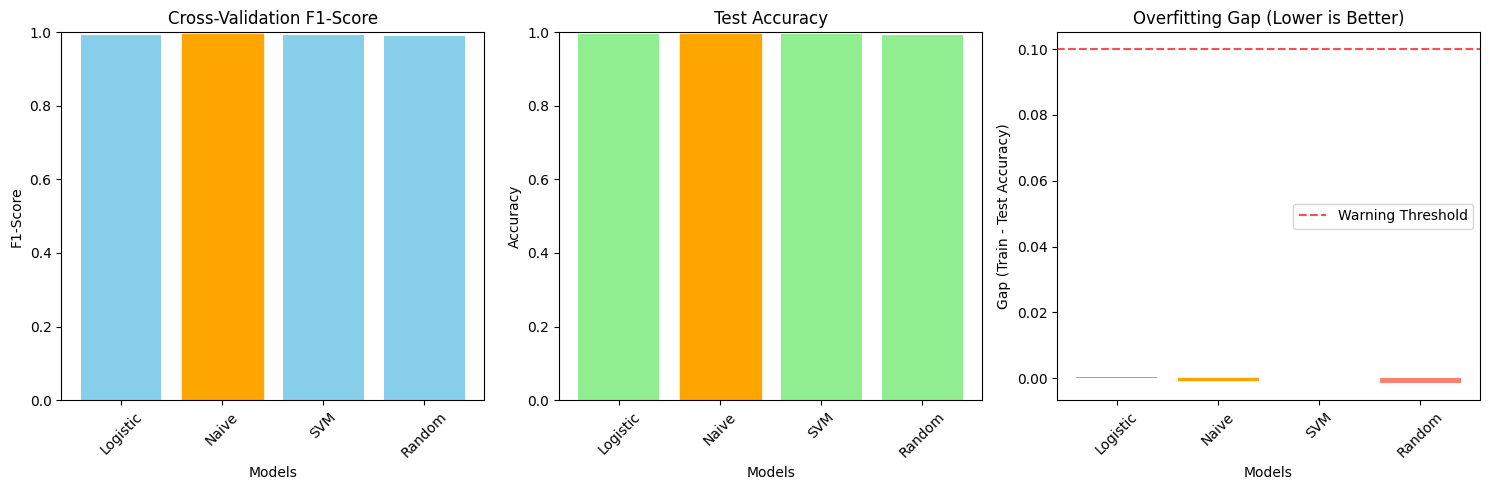

In [6]:
# Cell 6: Model Comparison dan Best Model Selection

# Ringkasan hasil
print(f"\n{'='*60}")
print("RINGKASAN HASIL")
print(f"{'='*60}")

results_df = pd.DataFrame({
    name: {
        'CV Accuracy': f"{result['cv_accuracy']:.3f}",
        'CV F1-Score': f"{result['cv_f1']:.3f}",
        'Test Accuracy': f"{result['test_accuracy']:.3f}",
        'Train Accuracy': f"{result['train_accuracy']:.3f}",
        'Overfitting Gap': f"{result['overfitting_gap']:.3f}"
    }
    for name, result in results.items()
}).T

print(results_df)

# Pilih model terbaik berdasarkan CV F1-Score (lebih balanced daripada accuracy)
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_f1'])
best_pipeline = results[best_model_name]['pipeline']

print(f"\n🏆 Model terbaik: {best_model_name}")
print(f"CV F1-Score: {results[best_model_name]['cv_f1']:.3f}")
print(f"Test Accuracy: {results[best_model_name]['test_accuracy']:.3f}")
print(f"Overfitting Gap: {results[best_model_name]['overfitting_gap']:.3f}")

# Visualisasi perbandingan model
plt.figure(figsize=(15, 5))

# CV F1-Score comparison
plt.subplot(1, 3, 1)
model_names = list(results.keys())
cv_f1_scores = [results[name]['cv_f1'] for name in model_names]
bars1 = plt.bar(range(len(model_names)), cv_f1_scores, color='skyblue')
plt.title('Cross-Validation F1-Score')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.xticks(range(len(model_names)), [name.split()[0] for name in model_names], rotation=45)
plt.ylim(0, 1)

# Highlight best model
best_idx = model_names.index(best_model_name)
bars1[best_idx].set_color('orange')

# Test Accuracy comparison
plt.subplot(1, 3, 2)
test_accuracies = [results[name]['test_accuracy'] for name in model_names]
bars2 = plt.bar(range(len(model_names)), test_accuracies, color='lightgreen')
plt.title('Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(range(len(model_names)), [name.split()[0] for name in model_names], rotation=45)
plt.ylim(0, 1)

# Highlight best model
bars2[best_idx].set_color('orange')

# Overfitting Gap comparison
plt.subplot(1, 3, 3)
overfitting_gaps = [results[name]['overfitting_gap'] for name in model_names]
bars3 = plt.bar(range(len(model_names)), overfitting_gaps, color='salmon')
plt.title('Overfitting Gap (Lower is Better)')
plt.xlabel('Models')
plt.ylabel('Gap (Train - Test Accuracy)')
plt.xticks(range(len(model_names)), [name.split()[0] for name in model_names], rotation=45)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Warning Threshold')
plt.legend()

# Highlight best model
bars3[best_idx].set_color('orange')

plt.tight_layout()
plt.show()

🔧 Fine-tuning model terbaik: Naive Bayes
⏳ Melakukan grid search... (ini mungkin memakan waktu)
Fitting 3 folds for each of 81 candidates, totalling 243 fits
✅ Grid search selesai!
Best parameters: {'classifier__alpha': 1.0, 'tfidf__max_df': 0.7, 'tfidf__max_features': 1500, 'tfidf__min_df': 2}
Best CV F1-score: 0.995

🎯 HASIL FINAL:
Test Accuracy: 0.996
Train Accuracy: 0.997
Overfitting Gap: 0.001

Classification Report (Final Model):
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1496
        True       0.99      1.00      1.00      1504

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



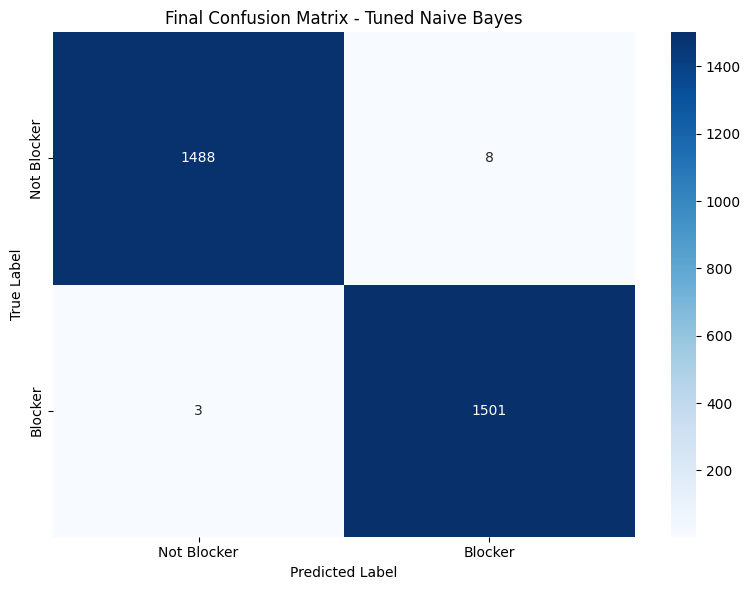

In [7]:
# Cell 7: Hyperparameter Tuning

print(f"🔧 Fine-tuning model terbaik: {best_model_name}")

# Parameter grid berdasarkan model terbaik
if 'Logistic' in best_model_name:
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__class_weight': ['balanced', None],
        'tfidf__max_features': [500, 1000, 1500],
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [0.7, 0.8, 0.9]
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42)
    
elif 'Naive' in best_model_name:
    param_grid = {
        'classifier__alpha': [0.1, 1.0, 10.0],
        'tfidf__max_features': [500, 1000, 1500],
        'tfidf__min_df': [2, 3, 5],
        'tfidf__max_df': [0.7, 0.8, 0.9]
    }
    base_model = MultinomialNB()
    
elif 'SVM' in best_model_name:
    param_grid = {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__class_weight': ['balanced', None],
        'tfidf__max_features': [500, 1000, 1500],
        'tfidf__min_df': [2, 3, 5]
    }
    base_model = SVC(kernel='linear', random_state=42)
    
else:  # Random Forest
    param_grid = {
        'classifier__n_estimators': [30, 50, 100],
        'classifier__max_depth': [5, 10, 15],
        'classifier__min_samples_split': [5, 10, 15],
        'classifier__class_weight': ['balanced', None],
        'tfidf__max_features': [500, 1000, 1500]
    }
    base_model = RandomForestClassifier(random_state=42)

# Grid search dengan cross-validation
grid_search = GridSearchCV(
    create_robust_pipeline(base_model),
    param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3-fold untuk speed
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("⏳ Melakukan grid search... (ini mungkin memakan waktu)")
grid_search.fit(X_train, y_train)

print(f"✅ Grid search selesai!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.3f}")

# Evaluasi model terbaik setelah tuning
final_predictions = grid_search.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)
final_train_predictions = grid_search.predict(X_train)
final_train_accuracy = accuracy_score(y_train, final_train_predictions)

print(f"\n🎯 HASIL FINAL:")
print(f"Test Accuracy: {final_accuracy:.3f}")
print(f"Train Accuracy: {final_train_accuracy:.3f}")
print(f"Overfitting Gap: {final_train_accuracy - final_accuracy:.3f}")

print(f"\nClassification Report (Final Model):")
print(classification_report(y_test, final_predictions))

# Confusion Matrix final
cm_final = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Blocker', 'Blocker'],
            yticklabels=['Not Blocker', 'Blocker'])
plt.title(f'Final Confusion Matrix - Tuned {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Simpan model terbaik
final_model = grid_search.best_estimator_

In [8]:
# Cell 8: Save Model dan Feature Analysis

# Save model dan preprocessing info
model_data = {
    'model': final_model,
    'model_name': best_model_name,
    'vectorizer_params': final_model.named_steps['tfidf'].get_params(),
    'performance': {
        'cv_f1_score': grid_search.best_score_,
        'test_accuracy': final_accuracy,
        'train_accuracy': final_train_accuracy,
        'overfitting_gap': final_train_accuracy - final_accuracy
    },
    'best_params': grid_search.best_params_
}

# Save ke file
joblib.dump(model_data, 'blocker_classifier_model.pkl')
print("✅ Model disimpan sebagai 'blocker_classifier_model.pkl'")

# Save hanya model untuk penggunaan langsung
joblib.dump(final_model, 'blocker_model_only.pkl')
print("✅ Model pipeline disimpan sebagai 'blocker_model_only.pkl'")

# Analisis feature importance (jika model mendukung)
def analyze_important_features(pipeline, n_features=20):
    """Analyze feature importance dari model yang telah dilatih"""
    try:
        # Get feature names
        feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
        
        # Get coefficients from the model
        if hasattr(pipeline.named_steps['classifier'], 'coef_'):
            coefficients = pipeline.named_steps['classifier'].coef_[0]
            
            # Create DataFrame of features and their coefficients
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': abs(coefficients)
            })
            
            # Sort by absolute importance
            feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
            
            print(f"\n🔍 Top {n_features} Most Important Features:")
            print("="*50)
            for i, row in feature_importance.head(n_features).iterrows():
                direction = "BLOCKER" if row['coefficient'] > 0 else "NOT BLOCKER"
                print(f"{row['feature']:25} | {row['coefficient']:+6.3f} | {direction}")
            
            # Plot top features
            plt.figure(figsize=(12, 8))
            top_features = feature_importance.head(n_features)
            colors = ['red' if coef > 0 else 'blue' for coef in top_features['coefficient']]
            
            plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Coefficient Value')
            plt.title(f'Top {n_features} Feature Coefficients\n(Red=Indicates Blocker, Blue=Indicates Not Blocker)')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
            return feature_importance
            
        elif hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
            # For tree-based models
            importances = pipeline.named_steps['classifier'].feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print(f"\n🔍 Top {n_features} Most Important Features:")
            print("="*50)
            for i, row in feature_importance.head(n_features).iterrows():
                print(f"{row['feature']:25} | {row['importance']:.3f}")
            
            # Plot top features
            plt.figure(figsize=(12, 8))
            top_features = feature_importance.head(n_features)
            plt.barh(range(len(top_features)), top_features['importance'], color='green', alpha=0.7)
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top {n_features} Most Important Features')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
            return feature_importance
            
    except Exception as e:
        print(f"⚠️ Tidak dapat menganalisis feature importance: {str(e)}")
        return None

# Analisis feature importance
feature_importance_df = analyze_important_features(final_model, n_features=20)

# Function untuk testing model
def test_model_prediction(text, model=final_model):
    """Test prediksi model dengan input teks"""
    prediction = model.predict([text])[0]
    probabilities = model.predict_proba([text])[0]
    confidence = max(probabilities)
    
    result = {
        'text': text,
        'is_blocker': bool(prediction),
        'confidence': float(confidence),
        'probabilities': {
            'not_blocker': float(probabilities[0]),
            'blocker': float(probabilities[1])
        }
    }
    
    return result

# Test beberapa contoh kasus
test_cases = [
    "ada kendala saya terhambat belum bisa melanjutkan ke bagian lain",
    "Terkendala karena API dari tim backend belum ready",
    "Sudah selesai 80% pengerjaan task",
    "Menunggu approval dari product owner",
    "Lagi deploy ke staging environment",
    "Butuh bantuan untuk setup database",
    "Update: implementasi sudah selesai",
    "Tidak bisa lanjut karena server down"
]

print("\n🧪 Testing Model dengan Beberapa Contoh:")
print("="*70)
for text in test_cases:
    result = test_model_prediction(text)
    status = "🚫 BLOCKER" if result['is_blocker'] else "✅ NOT BLOCKER"
    print(f"\nInput: {text}")
    print(f"Prediction: {status}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Probabilitas Blocker: {result['probabilities']['blocker']:.2%}")
    print(f"Probabilitas Not Blocker: {result['probabilities']['not_blocker']:.2%}")
    print("-"*70)

# Evaluasi performa model secara keseluruhan
print("\n📊 Evaluasi Model:")
print("="*50)
print(f"Model: {best_model_name}")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-validation F1 Score: {grid_search.best_score_:.3f}")
print(f"Test Accuracy: {final_accuracy:.3f}")
print(f"Train Accuracy: {final_train_accuracy:.3f}")
print(f"Overfitting Gap: {(final_train_accuracy - final_accuracy):.3f}")

# Function untuk menyimpan hasil evaluasi
def save_evaluation_report(model_data, filename='model_evaluation_report.txt'):
    """Simpan hasil evaluasi model ke file"""
    with open(filename, 'w') as f:
        f.write("BLOCKER DETECTION MODEL EVALUATION REPORT\n")
        f.write("="*50 + "\n\n")
        
        f.write("MODEL INFORMATION:\n")
        f.write(f"Model Type: {model_data['model_name']}\n")
        f.write(f"Best Parameters: {model_data['best_params']}\n\n")
        
        f.write("PERFORMANCE METRICS:\n")
        f.write(f"Cross-validation F1 Score: {model_data['performance']['cv_f1_score']:.3f}\n")
        f.write(f"Test Accuracy: {model_data['performance']['test_accuracy']:.3f}\n")
        f.write(f"Train Accuracy: {model_data['performance']['train_accuracy']:.3f}\n")
        f.write(f"Overfitting Gap: {model_data['performance']['overfitting_gap']:.3f}\n\n")
        
        f.write("VECTORIZER PARAMETERS:\n")
        for param, value in model_data['vectorizer_params'].items():
            f.write(f"{param}: {value}\n")
            
    print(f"✅ Evaluation report saved as '{filename}'")

# Simpan report evaluasi
save_evaluation_report(model_data)

print("\n✨ Analisis Model Selesai!")
print("="*50)
print("📁 Files yang dihasilkan:")
print("1. blocker_classifier_model.pkl - Model lengkap dengan metadata")
print("2. blocker_model_only.pkl - Pipeline model untuk penggunaan")
print("3. model_evaluation_report.txt - Laporan evaluasi detail")

✅ Model disimpan sebagai 'blocker_classifier_model.pkl'
✅ Model pipeline disimpan sebagai 'blocker_model_only.pkl'

🧪 Testing Model dengan Beberapa Contoh:

Input: ada kendala saya terhambat belum bisa melanjutkan ke bagian lain
Prediction: ✅ NOT BLOCKER
Confidence: 85.49%
Probabilitas Blocker: 14.51%
Probabilitas Not Blocker: 85.49%
----------------------------------------------------------------------

Input: Terkendala karena API dari tim backend belum ready
Prediction: 🚫 BLOCKER
Confidence: 97.38%
Probabilitas Blocker: 97.38%
Probabilitas Not Blocker: 2.62%
----------------------------------------------------------------------

Input: Sudah selesai 80% pengerjaan task
Prediction: ✅ NOT BLOCKER
Confidence: 98.58%
Probabilitas Blocker: 1.42%
Probabilitas Not Blocker: 98.58%
----------------------------------------------------------------------

Input: Menunggu approval dari product owner
Prediction: 🚫 BLOCKER
Confidence: 98.73%
Probabilitas Blocker: 98.73%
Probabilitas Not Blocker: 1